#Reactor Example Code

In [0]:
!pip install aguaclara

     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 163kB 15.5MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.0-cp36-none-any.whl size=99623 sha256=a5091cbf7c9bbb1e930bf0f86554f71043a60b4f5ab45f448edbd6a962dd6de6
  Stored in directory: /root/.cache/pip/wheels/34/e9/34/0d3722243083a982623290c205c14a08b54ed290ee29219fd2
  Created wheel for pint: filename=Pint-0.8.1-py2.py3-none-any.whl size=134156 sha256=c7e50608202bb56f11c04bc8505fd15a2b173385e5841659ed6b8f08b24b1428
  Stored in directory: /root/.cache/pip/wheels/b4/56/36/7c4d6a4e3660e233b95e3b0482551915cb184abca0f93ee1dd
Successfully built aguaclara pint


In [0]:
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
import numpy as np
import matplotlib.pyplot as plt

#issues to improve

* devise an equation to estimate required tracer mass based on estimated N or Pe.
* Devise a better method to estimate tstar. I think it should be based on the theta that is calculated from flow and reactor volume. THis requires that we have a good method of creating an F curve without having all of the data. I think the F curve should be made from the best fit E curve rather than from the raw data. This will eliminate the error of not knowing exactly what the mass of added tracer is.
* Devise a method to test for dead volume or short circuiting (same thing). Is this simply a comparison of theta from V/Q with tbar from the E curve fit?

# Reactor analysis

We would like to understand the mixing characteristics of the various reactors that we are designing and building. The parameters that describe the reactors are the number of CMFRs in series or the Peclet number and the ratio of the hydraulic residence time to the tracer residence time. We will use scipy.optimize curve_fit to minimize the error between our two reactor models (CMFR in series and advection/dispersion) and the tracer data that we collect.

The model estimated mass of tracer injected was 35 milligram
The model estimate of the number of reactors in series was 1.0
The tracer residence time was 240 second
The ratio of tracer to hydraulic residence time was 1.0


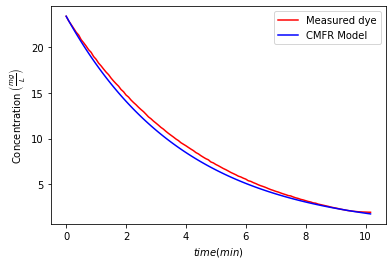

The best it for  26.09 milligram / liter
The model estimated mass of tracer injected was 85 milligram
The model estimate of the Peclet number was 3.4641301691526003
The tracer residence time was 190 second
The ratio of tracer to hydraulic residence time was 0.5221969583071777
the deltat was 5 second
The contact time is 0.5022 dimensionless


/usr/local/lib/python3.6/dist-packages/pint/quantity.py:839: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__(other_magnitude / self._magnitude, 1 / self._units)
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:802: RuntimeWarning: divide by zero encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:802: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


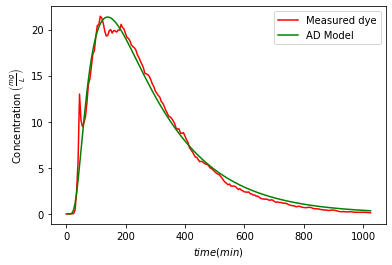

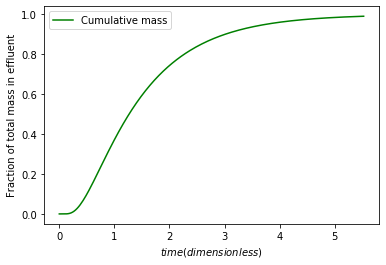

In [0]:

#The following file is from a CMFR
CMFR_path = 'https://raw.githubusercontent.com/monroews/CEE4530/master/Examples/data/CMFR_example.xls'

# find the row after the last note in the file. This assumes that the last note marks the beginning of the test.
ac.notes(CMFR_path)
CMFR_firstrow = ac.notes(CMFR_path).last_valid_index() + 1
CMFR_firstrow

#I eliminate the beginning of the data file because this is a CMFR and the
#first data was taken before the dye reached the sensor. Note that eliminating
#some data from the beginning of the data file will not change the analysis
#except in the estimate of the initial tracer mass.#
CMFR_firstrow = CMFR_firstrow + 10


CMFR_time_data = (ac.column_of_time(CMFR_path,CMFR_firstrow,-1)).to(u.s)

CMFR_concentration_data = ac.column_of_data(CMFR_path,CMFR_firstrow,1,-1,'mg/L')

#I don't actually know the values that follow. I'm guessing.
#You should use real measured values!#
CMFR_V = 1.5*u.L
CMFR_Q = 380 * u.mL/u.min

#here we set estimates that we will use as starting values for the curve fitting
CMFR_theta_hydraulic = (CMFR_V/CMFR_Q).to(u.s)
CMFR_C_bar_guess = np.max(CMFR_concentration_data)

#The Solver_CMFR_N will return the initial tracer concentration,
#residence time, and number of reactors in series.
#This experiment was for a single reactor and so we expect N to be 1!
CMFR_CMFR = ac.Solver_CMFR_N(CMFR_time_data, CMFR_concentration_data, CMFR_theta_hydraulic, CMFR_C_bar_guess)
#use dot notation to get the 3 elements of the tuple that are in CMFR.

print('The model estimated mass of tracer injected was',ac.round_sig_figs(CMFR_CMFR.C_bar*CMFR_V ,2) )
print('The model estimate of the number of reactors in series was', CMFR_CMFR.N)
print('The tracer residence time was',ac.round_sig_figs(CMFR_CMFR.theta ,2))
print('The ratio of tracer to hydraulic residence time was',(CMFR_CMFR.theta/CMFR_theta_hydraulic).magnitude)

#create a model curve given the curve fit parameters.

CMFR_CMFR_model = CMFR_CMFR.C_bar * ac.E_CMFR_N(CMFR_time_data/CMFR_CMFR.theta,CMFR_CMFR.N)
plt.plot(CMFR_time_data.to(u.min), CMFR_concentration_data.to(u.mg/u.L),'r')
plt.plot(CMFR_time_data.to(u.min), CMFR_CMFR_model,'b')

plt.xlabel(r'$time (min)$')
plt.ylabel(r'Concentration $\left ( \frac{mg}{L} \right )$')
plt.legend(['Measured dye','CMFR Model'])
plt.show()

#Load a data file for a reactor with baffles.

one_baffle_path = 'https://raw.githubusercontent.com/monroews/CEE4530/master/Examples/data/Dispersion_example.xls'
one_baffle_firstrow = ac.notes(one_baffle_path).last_valid_index() + 1
one_baffle_time_data = (ac.column_of_time(one_baffle_path,one_baffle_firstrow,-1)).to(u.s)
one_baffle_concentration_data = ac.column_of_data(one_baffle_path,one_baffle_firstrow,1,-1,'mg/L')

#I noticed that the initial concentration measured by the photometer wasn't
#zero. This suggests that there may have been a small air bubble in the
#photometer or perhaps there was some other anomoly that was causing the
#photometer to read a concentration that was higher than was actually present in
#the reactor. To correct for this I subtracted the initial concentration reading
#from all of the data. This was based on the assumption that the concentration
#measurement error persisted for the entire experiment.#

one_baffle_concentration_data = one_baffle_concentration_data - one_baffle_concentration_data[0]
one_baffle_V = 2.25*u.L
one_baffle_Q = 380 * u.mL/u.min
one_baffle_theta_hydraulic = (one_baffle_V/one_baffle_Q).to(u.s)
one_baffle_C_bar_guess = np.max(one_baffle_concentration_data)/2
#use solver to get the CMFR parameters
one_baffle_CMFR = ac.Solver_CMFR_N(one_baffle_time_data, one_baffle_concentration_data, one_baffle_theta_hydraulic, one_baffle_C_bar_guess)
print('The best it for ',one_baffle_CMFR.C_bar)
one_baffle_CMFR.N
one_baffle_CMFR.theta.to(u.s)

#Create the CMFR model curve based on the scipy.optimize curve_fit
#parameters. We do this with dimensions so that we can plot both models and
#the data on the same graph. If we did this in dimensionless space it wouldn't
#be possible to plot everything on the same plot because the values used to
#create dimensionless time and dimensionless concentration are different for
#the two models.
one_baffle_CMFR_model = (one_baffle_CMFR.C_bar*ac.E_CMFR_N(one_baffle_time_data/one_baffle_CMFR.theta, one_baffle_CMFR.N)).to(u.mg/u.L)

#use solver to get the advection dispersion parameters
one_baffle_AD = ac.Solver_AD_Pe(one_baffle_time_data, one_baffle_concentration_data, one_baffle_theta_hydraulic, one_baffle_C_bar_guess)
one_baffle_AD.C_bar
one_baffle_AD.Pe
one_baffle_AD.theta

print('The model estimated mass of tracer injected was',ac.round_sig_figs(one_baffle_AD.C_bar*one_baffle_V ,2) )
print('The model estimate of the Peclet number was', one_baffle_AD.Pe)
print('The tracer residence time was',ac.round_sig_figs(one_baffle_AD.theta ,2))
print('The ratio of tracer to hydraulic residence time was',(one_baffle_AD.theta/one_baffle_theta_hydraulic).magnitude)

#Create the advection dispersion model curve based on the solver parameters
one_baffle_AD_model = (one_baffle_AD.C_bar*ac.E_Advective_Dispersion((one_baffle_time_data/one_baffle_AD.theta).to_base_units(), one_baffle_AD.Pe)).to(u.mg/u.L)

# the AD model returns a nan for time zero. fix this!
one_baffle_AD_model_e = ac.E_Advective_Dispersion((one_baffle_time_data/one_baffle_AD.theta).to_base_units(), one_baffle_AD.Pe)
# the AD model returns a nan for time zero. fix this!
one_baffle_AD_model_e[0]=0

# the integration is with respect to time and thus we need to account for the data time interval that we used.
deltat = one_baffle_time_data[-1]/(one_baffle_time_data.size - 1)
print('the deltat was',deltat)

one_baffle_AD_model_f = np.cumsum(one_baffle_AD_model_e) * deltat/one_baffle_AD.theta

# need to reapply units to this numpy function. Not sure why it loses the y units.
one_baffle_BF = (np.interp(0.1,one_baffle_AD_model_f,one_baffle_time_data))*u.s/one_baffle_AD.theta

print('The contact time is',one_baffle_BF)

#Plot the data and the two model curves.
plt.plot(one_baffle_time_data.to(u.s), one_baffle_concentration_data.to(u.mg/u.L),'r')
#plt.plot(one_baffle_time_data.to(u.s), one_baffle_CMFR_model,'b')
plt.plot(one_baffle_time_data.to(u.s), one_baffle_AD_model,'g')
plt.xlabel(r'$time (min)$')
plt.ylabel(r'Concentration $\left ( \frac{mg}{L} \right )$')
plt.legend(['Measured dye', 'AD Model'])
plt.show()

plt.plot(one_baffle_time_data.to(u.s)/one_baffle_AD.theta, one_baffle_AD_model_f,'g')
plt.xlabel(r'$time (dimensionless)$')
plt.ylabel('Fraction of total mass in effluent')
plt.legend(['Cumulative mass'])
plt.show()